## TODO: Add shoulders and hips to error calculation

In [9]:
import HelperFcns
import pandas as pd
import numpy as np
import json, itertools
import itertools

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from RTOUtil.general import *

In [2]:
BoxPath = Path(setLocalPath('BoxPath'))
KyleLabel = BoxPath/'Metadata'/'CISPD - Video Summary.xlsx'
jsonPath = BoxPath/'OpenPose'/'outputKE'

In [3]:
KyleLabel

PosixPath('/Users/nicholasshawen/Box/CISPD_Videos_proc/Metadata/CISPD - Video Summary.xlsx')

In [427]:
KL = pd.read_excel(KyleLabel,skiprows=1)
KL.head()

,subject number,filename,original file order,Pose video exists,total number of people visible,people with more than 1/2 torso or face in frame at any time,subject stance,perspective,where is subject torso is relative to frame,subject torso relative to other people in frame,this body part and up are in frame,body part obstructed,obstructed by what?,lots of camera movement,notes,tracking quality (confidence)
0,1003,FtnL_1,1,0,3,3,seated,right,left,leftmost,above hips,shoulder,door,NaN,NaN,NaN
1,1003,FtnL_3,2,0,2,1,seated,right,left,leftmost,above hips,NaN,NaN,NaN,slight frontal view,NaN
2,1003,FtnR_1,3,0,3,3,seated,right,left,leftmost,above hips,shoulder,door,NaN,NaN,NaN
3,1003,FtnR_3,4,0,3,3,seated,right,left,leftmost,above hips,shoulder,door,NaN,NaN,NaN
4,1003,RamL_1,5,0,1,1,seated,front/right,center,only,above knees,NaN,NaN,NaN,NaN,NaN


In [436]:
KL[KL.iloc[:,4]>3]

,subject number,filename,original file order,Pose video exists,total number of people visible,people with more than 1/2 torso or face in frame at any time,subject stance,perspective,where is subject torso is relative to frame,subject torso relative to other people in frame,this body part and up are in frame,body part obstructed,obstructed by what?,lots of camera movement,notes,tracking quality (confidence)
8,1004,FtnL_1,9,1,4,1,seated,front/right,center,leftmost,whole body,NaN,NaN,NaN,this subject: low res and vertical,NaN
9,1004,FtnL_3,10,1,4,2,seated,front/right,center,leftmost,whole body,NaN,NaN,yes,NaN,NaN
10,1004,FtnR_1,11,1,4,1,seated,front/right,center,leftmost,whole body,knees,clinician,NaN,NaN,NaN
11,1004,FtnR_3,12,1,6,4,seated,front/right,left,leftmost,whole body,NaN,NaN,yes,We have an example plot showing bad tracking t...,NaN
13,1004,RamL_3,14,1,4,2,seated,front/right,left,leftmost,whole body,NaN,NaN,NaN,NaN,NaN


In [750]:
KL.iloc[:,1].unique()

array(['FtnL_1', 'FtnL_3', 'FtnR_1', 'FtnR_3', 'RamL_1', 'RamL_3',
       'RamR_1', 'RamR_3', 'FtnL_2', 'FtnR_2', 'RamL_2', 'RamR_2',
       'FtnL_4', 'FtnR_4', 'RamL_4', 'RamR_4', 'RmL_2'], dtype=object)

In [432]:
PatLocCol = KL.columns[8]
PatRelCol = KL.columns[9]

In [431]:
KL[PatLocCol].unique()

array(['left', 'center', 'center ', 'right'], dtype=object)

In [433]:
KL[PatRelCol].unique()

array(['leftmost', 'only', 'rightmost', 'center'], dtype=object)

In [5]:
def DataParser(D, subj, task, cycle):
    if 'pose_keypoints_2d' in D.keys():
        pose = D['pose_keypoints_2d']
        pose_hand_L = D['hand_left_keypoints_2d']
        pose_hand_R = D['hand_right_keypoints_2d']
        d = {'SubjID':subj, 'Task':task, 'cycle':cycle,
                 'elbR_x':pose[9], 'elbR_y':pose[10], 'elbR_c':pose[11], 'wriR_x':pose[12], 'wriR_y':pose[13], 'wriR_c':pose[14],
                 'elbL_x':pose[18], 'elbL_y':pose[19], 'elbL_c':pose[20], 'wriL_x':pose[21], 'wriL_y':pose[22], 'wriL_c':pose[23],
                 'nose_x':pose[0], 'nose_y':pose[1], 'nose_c':pose[2], 'neck_x':pose[3], 'neck_y':pose[4], 'neck_c':pose[5],
                 'midHip_x':pose[24], 'midHip_y':pose[25], 'midHip_c':pose[26],
                 'thumbR_x':pose_hand_R[12], 'thumbR_y':pose_hand_R[13], 'thumbR_c':pose_hand_R[14],
                 'indexR_x':pose_hand_R[24], 'indexR_y':pose_hand_R[25], 'indexR_c':pose_hand_R[26],
                 'midR_x':pose_hand_R[36], 'midR_y':pose_hand_R[37], 'midR_c':pose_hand_R[38],
                 'ringR_x':pose_hand_R[48], 'ringR_y':pose_hand_R[49], 'ringR_c':pose_hand_R[50],
                 'pinkyR_x':pose_hand_R[60], 'pinkyR_y':pose_hand_R[61], 'pinkyR_c':pose_hand_R[62],
                 'thumbL_x':pose_hand_L[12], 'thumbL_y':pose_hand_L[13], 'thumbL_c':pose_hand_L[14],
                 'indexL_x':pose_hand_L[24], 'indexL_y':pose_hand_L[25], 'indexL_c':pose_hand_L[26],
                 'midL_x':pose_hand_L[36], 'midL_y':pose_hand_L[37], 'midL_c':pose_hand_L[38],
                 'ringL_x':pose_hand_L[48], 'ringL_y':pose_hand_L[49], 'ringL_c':pose_hand_L[50],
                 'pinkyL_x':pose_hand_L[60], 'pinkyL_y':pose_hand_L[61], 'pinkyL_c':pose_hand_L[62]}
        
        for k in [k for k in d.keys() if k.find('_c')==-1]:
            if d[k]==0:
                d[k]=np.nan
        
        return d
    else:
        return D

In [417]:
def CheckDist(new,old,columns):
    
    if len(new)>len(old):
        oldIDs = old.PersonID.values
        matchIDs = []
        newIDs = list(new.PersonID.values)
        for old_row in old.iterrows():

            dist = []
            for new_row in new.iterrows():

                diff = new_row[1].loc[columns]-old_row[1].loc[columns]
                if not diff.isnull().all():
                    dist.append(np.nanmean(diff.astype('float64').values**2))
                else:
                    dist.append(np.nan)

            matchID = np.nanargmin(dist)
            matchIDs.append(matchID)

        for match, old in zip(matchIDs,oldIDs):
            newIDs[match]=old

        count=0
        for i in range(len(newIDs)):
            if i not in matchIDs:
                count+=1
                newIDs[i] = max(oldIDs)+count
    
    else:
        oldIDs = old.PersonID.values
        newIDs = []
        for new_row in new.iterrows():

            dist = []
            for old_row in old.iterrows():

                diff = new_row[1].loc[columns]-old_row[1].loc[columns]
                if not diff.isnull().all():
                    dist.append(np.nanmean(diff.astype('float64').values**2))
                else:
                    dist.append(np.nan)

#             print(dist)
            if all(np.isnan(dist)):
                newID = -1
            else:
                newID = oldIDs[np.nanargmin(dist)]
            newIDs.append(newID)
    
    return newIDs
    

In [775]:
def SimpPerson(Persons):
    
    DC = [c for c in Persons.columns if c.find('_')>-1] # data columns
    LC_x = [c for c in DC if (c.find('_x')>-1)] #location columns
    LC_y = [c for c in DC if (c.find('_y')>-1)] #location columns

    stop = False
    while not stop:
        dist = {}
        for i,j in itertools.combinations(Persons.index.values,2):
            rowI = Persons.loc[i,:]
            rowJ = Persons.loc[j,:]
            if ((~rowI.loc[LC_x+LC_y].isnull()) & (~rowJ.loc[LC_x+LC_y].isnull())).any():
                 continue

#             print(rowI.loc[LC_x],rowJ.loc[LC_x])
            d = abs(np.nanmean(rowI.loc[LC_x].values)-np.nanmean(rowJ.loc[LC_x].values))
            d += abs(np.nanmean(rowI.loc[LC_y].values)-np.nanmean(rowJ.loc[LC_y].values))
            dist[d] = (i,j)

        usedInd = []
        for d in sorted(dist.keys()):

            i,j = dist[d]
            if (i not in usedInd) and (j not in usedInd):

                Persons.loc[i,DC] = np.nansum([Persons.loc[i,:].loc[DC].values,Persons.loc[j,:].loc[DC].values],axis=0)
                Persons.drop(index=[j],inplace=True)
                usedInd+=[i,j]

        if len(dist.keys())==0:
            stop=True

        Persons.loc[:,LC_x+LC_y] = Persons.loc[:,LC_x+LC_y].replace(0,np.nan)
        Persons.reset_index(inplace=True,drop=True)

In [781]:
def CheckOverlap(Persons):
    
    DC = [c for c in Persons.columns if c.find('_')>-1] # data columns
    LC = [c for c in DC if (c.find('_x')>-1) or (c.find('_y')>-1)]
    LC_x = [c for c in DC if c in ['nose_x','neck_x','midHip_x']] #location columns
    LC_y = [c for c in DC if c in ['nose_y','neck_y','midHip_y']] #location columns
    
    dist = {}
    for i,j in itertools.combinations(Persons.index.values,2):
        rowI = Persons.loc[i,:]
        rowJ = Persons.loc[j,:]
        if rowI.loc[LC_x+LC_y].isnull().all() | rowJ.loc[LC_x+LC_y].isnull().all():
             continue

        d = abs(np.nanmean(rowI.loc[LC_x].values)-np.nanmean(rowJ.loc[LC_x].values))
        d += abs(np.nanmean(rowI.loc[LC_y].values)-np.nanmean(rowJ.loc[LC_y].values))
        dist[d] = (i,j)
       
    usedInd = []
    for d in sorted(dist.keys()):
        if (d<100) and (i not in usedInd) and (j not in usedInd):
            i,j = dist[d]
            
            shared = [c for c in LC if (not np.isnan(Persons.loc[i,c])) and (not np.isnan(Persons.loc[j,c]))]
            shared += [stem+'_c' for stem in np.unique([c.split('_')[0] for c in shared])]
            unshared = [c for c in DC if c not in shared]
            
            Persons.loc[i,shared] = np.nanmean([Persons.loc[i,shared].values,Persons.loc[j,shared].values],axis=0)
            Persons.loc[i,unshared] = np.nansum([Persons.loc[i,unshared].values,Persons.loc[j,unshared].values],axis=0)
            Persons.drop(index=[j],inplace=True)
            Persons.loc[:,LC_x+LC_y].replace(np.float(0),np.nan,inplace=True)
            usedInd+=[i,j]
            

In [460]:
def getPID(df,absLoc,relLoc):
    
    centers_x = []
    centers_y = []
    IDs = [v for v in df.PersonID.unique() if v>=0]
    for ID in IDs:
        centers_x.append(np.nanmean(df[df.PersonID==ID].loc[:,['nose_x','neck_x','midHip_x']]))
        centers_y.append(np.nanmean(df[df.PersonID==ID].loc[:,['nose_y','neck_y','midHip_y']]))
        
    if relLoc=='leftmost':
        PID = np.argmin(centers_x)
    elif relLoc=='rightmost':
        PID = np.argmax(centers_x)
    else:
        PID = np.argmin((np.array(centers_x)-np.median(centers_x))**2)
    
    PID = IDs[PID]
    
    return PID

In [860]:
# columns for matching personIDs by minimizing frame-to-frame location change
EColumns = ['neck','midHip','nose']#,'elbR','elbL','wriL','wriR']
EColumns = [l for l in itertools.chain.from_iterable([[c+'_x',c+'_y'] for c in EColumns])]

S = os.listdir(jsonPath)
for subj in S[27:]:
    F = os.listdir(jsonPath/subj)
    T = list(np.unique([f.split('_')[0] for f in F]))
    for task in T:
        if task[0] not in ['F','R']:
            continue
        F_t = [f for f in F if f.find(task)>-1]
        C = list(np.unique([f.split('_')[1] for f in F_t]))
        for cycle in C:
            F_tc = [f for f in F_t if f.split('_')[1]==cycle]
            prevFrame = None
            print(subj,task,cycle)
            df = pd.DataFrame()
            for file in F_tc[:]:
                frame = int(file.split('_')[2])
                
                # seems to randomly fail to load files due to poor connection
                # catch these errors and try again until successful
                loaded = False
                while not loaded:
                    try:
                        with  open(jsonPath/subj/file,'r') as f:
                            data = json.load(f,object_hook=lambda x: DataParser(x,subj,task,cycle))['people']
                    except(TypeError):
                        print('Load Failure')
                        continue
                    except(OSError):
                        print('Load Failure')
                        continue
                    loaded = True
                    
                data = pd.DataFrame(data)
                LC = [c for c in data.columns if (c.find('_x')>-1) or (c.find('_x')>-1)]
                data.drop(index = data[data.loc[:,LC].isnull().all(axis=1)].index,inplace=True)
                data['PersonID'] = data.index.values
                data['FrameID'] = frame
                data['NPerson'] = len(data)
                SimpPerson(data)
                CheckOverlap(data)
                
                if prevFrame is not None:
                    newID = CheckDist(data,prevFrame,EColumns)
                    
                    if len(np.unique(newID))<len(newID):
                        print('Fail', frame)
                        break
                    
                    data['PersonID'] = newID
#                     print(newID,prevFrame.PersonID.values)
                    
                    for row in data.iterrows():
                        ID = row[1].PersonID
                        if all([np.isnan(v) for v in row[1].loc[EColumns].values]):
                            continue
                        if any(prevFrame.PersonID==ID):
                            
                            prevInd = prevFrame[prevFrame.PersonID==ID].index[0]
                            
                            # keep previous values for columns not identified this frame
                            nanInds = list(row[1].index[row[1].isnull()])
                            if len(nanInds)>0:
                                row[1].loc[nanInds] = prevFrame.loc[prevInd,nanInds]
                            
                            prevFrame.iloc[np.argmax(prevFrame.PersonID==ID),:] = row[1]
                        else:
                            prevFrame = pd.concat([prevFrame,data.loc[[row[0]],:]])
                            print(frame,len(prevFrame))
                            prevFrame.reset_index(drop=True,inplace=True)
                else:
                    if len(data)>0:
                        prevFrame = data
                        prevFrame.reset_index(drop=True,inplace=True)
                
#                 print(prevFrame.loc[:,EColumns],data.loc[:,EColumns])
                    
                df = pd.concat([df,data])
            
            df.reset_index(drop=True,inplace=True)
            
            pickleSave('_'.join([subj,task,cycle+'.pkl']),df)
            
            # drop intermittent identifications (probably not real people)
            counts = df.PersonID.value_counts()
            mCounts = counts.mean()
            for p in counts.index:
                if counts[p]<mCounts/2:
                    df.drop(index = df[df.PersonID==p].index,inplace=True)
                    
            df.reset_index(drop=True,inplace=True)
            
            KL_Filt = KL[(KL.iloc[:,0]==int(subj)) & (KL.iloc[:,1]=='_'.join([task,cycle]))]
            
            if len(KL_Filt)>0:
                RelLoc = KL_Filt.iloc[0,9]

                PID = getPID(df,None,RelLoc)

                pickleSave('_'.join([subj,task,cycle,'Pat.pkl']),df[df.PersonID==PID].copy())

1056 FtnL 1
1056 FtnL 2
1056 FtnR 1
Load Failure
Load Failure
Load Failure
1056 FtnR 2
1056 RamL 1
179 2
Load Failure
Load Failure
Fail 189
1056 RamL 2
57 2
Fail 267
1056 RamR 1
522 2
1056 RamR 2
80 2
Load Failure
Load Failure
Fail 250


In [852]:
with  open(jsonPath/subj/F_tc[0],'r') as f:
    data = json.load(f,object_hook=lambda x: DataParser(x,subj,task,cycle))['people']

In [853]:
data

[]

In [856]:
file

'FtnR_3_000000000000_keypoints.json'

In [851]:
F_tc

['FtnR_3_000000000000_keypoints.json',
 'FtnR_3_000000000001_keypoints.json',
 'FtnR_3_000000000002_keypoints.json',
 'FtnR_3_000000000003_keypoints.json',
 'FtnR_3_000000000004_keypoints.json',
 'FtnR_3_000000000005_keypoints.json',
 'FtnR_3_000000000006_keypoints.json',
 'FtnR_3_000000000007_keypoints.json',
 'FtnR_3_000000000008_keypoints.json',
 'FtnR_3_000000000009_keypoints.json',
 'FtnR_3_000000000010_keypoints.json',
 'FtnR_3_000000000011_keypoints.json',
 'FtnR_3_000000000012_keypoints.json',
 'FtnR_3_000000000013_keypoints.json',
 'FtnR_3_000000000014_keypoints.json',
 'FtnR_3_000000000015_keypoints.json',
 'FtnR_3_000000000016_keypoints.json',
 'FtnR_3_000000000017_keypoints.json',
 'FtnR_3_000000000018_keypoints.json',
 'FtnR_3_000000000019_keypoints.json',
 'FtnR_3_000000000020_keypoints.json',
 'FtnR_3_000000000021_keypoints.json',
 'FtnR_3_000000000022_keypoints.json',
 'FtnR_3_000000000023_keypoints.json',
 'FtnR_3_000000000024_keypoints.json',
 'FtnR_3_000000000025_key

In [849]:
frame

1

In [847]:
data

,SubjID,Task,cycle,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,...,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c,PersonID,FrameID,NPerson
0,1032,FtnR,3,365.554,827.539,0.449539,480.284,465.541,0.166676,583.272,...,0.02914,856.073,703.4,0.025533,854.728,683.214,0.015419,0,1,1


In [848]:
prevFrame

,PersonID,FrameID,NPerson


In [820]:
file

'FtnL_2_000000000626_keypoints.json'

In [821]:
with open(jsonPath/subj/file,'r') as f:
    data = json.load(f,object_hook=lambda x: DataParser(x,subj,task,cycle))['people']

In [809]:
prevFrame.loc[:,EColumns]

,neck_x,neck_y,midHip_x,midHip_y,nose_x,nose_y
0,578.689,59.2764,564.354,129.697,564.342,24.0061
1,360.736,174.1340,371.158,277.201,401.132,144.0790
2,600.874,178.0120,598.282,298.088,557.850,181.8990
3,590.438,60.5400,591.738,174.083,566.946,116.6490


In [799]:
prevInd

3

In [745]:
# columns for matching personIDs by minimizing frame-to-frame location change
EColumns = ['neck','midHip','nose']#,'elbR','elbL','wriL','wriR']
EColumns = [l for l in itertools.chain.from_iterable([[c+'_x',c+'_y'] for c in EColumns])]

S = os.listdir(jsonPath)
for subj in ['1003']:#S:
    F = os.listdir(jsonPath/subj)
    T = list(np.unique([f.split('_')[0] for f in F]))
    for task in ['SitStand']:#T:
        if task[0] not in ['F','R']:
            continue
        F_t = [f for f in F if f.find(task)>-1]
        C = list(np.unique([f.split('_')[1] for f in F_t]))
        for cycle in ['1']:#C:
            F_tc = [f for f in F_t if f.split('_')[1]==cycle]
            prevFrame = None
            print(subj,task,cycle)
            df = pd.DataFrame()
            for file in F_tc[:]:
                frame = int(file.split('_')[2])
                
                with open(jsonPath/subj/file,'r') as f:
                    data = json.load(f,object_hook=lambda x: DataParser(x,subj,task,cycle))['people']
                data = pd.DataFrame(data)
                data['PersonID'] = data.index.values
                data['FrameID'] = frame
                data['NPerson'] = len(data)
                SimpPerson(data)
                CheckOverlap(data)
                
                if prevFrame is not None:
                    newID = CheckDist(data,prevFrame,EColumns)
                    
                    if len(np.unique(newID))<len(newID):
                        print('Fail', frame)
                        break
                    
                    data['PersonID'] = newID
#                     print(newID,prevFrame.PersonID.values)
                    
                    for row in data.iterrows():
                        ID = row[1].PersonID
                        if all([np.isnan(v) for v in row[1].loc[EColumns].values]):
                            continue
                        if any(prevFrame.PersonID==ID):
                            
                            prevInd = prevFrame[prevFrame.PersonID==ID].index[0]
                            
                            # keep previous values for columns not identified this frame
                            nanInds = list(row[1].index[row[1].isnull()])
                            row[1].loc[nanInds] = prevFrame.loc[prevInd,nanInds]
                            
                            prevFrame.iloc[np.argmax(prevFrame.PersonID==ID),:] = row[1]
                        else:
                            prevFrame = pd.concat([prevFrame,data.loc[[row[0]],:]])
                            print(frame,len(prevFrame))       
                else:
                    prevFrame = data
                
#                 print(prevFrame.loc[:,EColumns],data.loc[:,EColumns])
                    
                df = pd.concat([df,data])
            
            df.reset_index(drop=True,inplace=True)
            
            pickleSave('_'.join([subj,task,cycle+'.pkl']),df)
            
            # drop intermittent identifications (probably not real people)
            counts = df.PersonID.value_counts()
            mCounts = counts.mean()
            for p in counts.index:
                if counts[p]<mCounts/2:
                    df.drop(index = df[df.PersonID==p].index,inplace=True)
                    
            df.reset_index(drop=True,inplace=True)
            
            RelLoc = KL[(KL.iloc[:,0]==int(subj)) & (KL.iloc[:,1]=='_'.join([task,cycle]))].iloc[0,9]
            
            PID = getPID(df,None,RelLoc)
            
            pickleSave('_'.join([subj,task,cycle,'Pat.pkl']),df[df.PersonID==PID].copy())

1003 SitStand 1
67 2


IndexError: single positional indexer is out-of-bounds

In [749]:
task

'SitStand'

In [747]:
KL[(KL.iloc[:,0]==int(subj)) & (KL.iloc[:,1]=='_'.join([task,cycle]))]

,subject number,filename,original file order,Pose video exists,total number of people visible,people with more than 1/2 torso or face in frame at any time,subject stance,perspective,where is subject torso is relative to frame,subject torso relative to other people in frame,this body part and up are in frame,body part obstructed,obstructed by what?,lots of camera movement,notes,tracking quality (confidence)


In [729]:
data0 = data.copy()

In [730]:
data0.loc[:,EColumns]

,neck_x,neck_y,midHip_x,midHip_y,nose_x,nose_y
0,NaN,NaN,NaN,NaN,85.945,247.836
1,NaN,NaN,1307.27,130.071,NaN,NaN


In [731]:
file = F_tc[22]
with open(jsonPath/subj/file,'r') as f:
    data = json.load(f,object_hook=lambda x: DataParser(x,subj,task,cycle))['people']
data = pd.DataFrame(data)
data['PersonID'] = data.index.values
data['FrameID'] = 311
data['NPerson'] = len(data)
SimpPerson(data)
CheckOverlap(data)

In [732]:
data.loc[:,EColumns+['PersonID']]

,neck_x,neck_y,midHip_x,midHip_y,nose_x,nose_y,PersonID
0,NaN,NaN,NaN,NaN,85.945,247.836,0
1,NaN,NaN,1307.27,130.071,NaN,NaN,2


In [733]:
prevFrame.loc[:,EColumns+['PersonID']]

,neck_x,neck_y,midHip_x,midHip_y,nose_x,nose_y,PersonID
0,7.81107,489.10,1310.290,132.986,88.8605,247.776,0
1,7.82014,483.14,182.973,983.534,103.5700,247.697,1


In [734]:
newID = CheckDist(data,prevFrame,EColumns)
newID

[0, 0]

In [671]:
df.FrameID.max()

0

In [837]:
D = pickleLoad('1005_FtnR_1_Pat.pkl')

In [838]:
D.PersonID.unique()

array([1])

<AxesSubplot:>

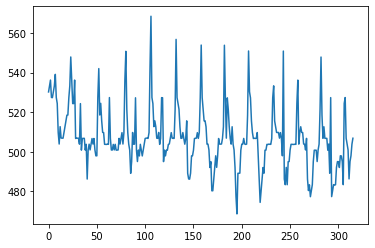

In [839]:
D.reset_index().wriR_y.plot()

In [64]:
import numpy as np
import scipy

In [73]:
scipy.stats.norm.cdf(1.28036879933)

0.8997922691537554

In [743]:
import cv2
path = BoxPath/'OpenPose'/'outputvideoKE'/'1003'/'FtnR_3.avi'
cap = cv2.VideoCapture(str(path.absolute()))
cap.set(cv2.CAP_PROP_POS_FRAMES, 22-1)
res, frame = cap.read()

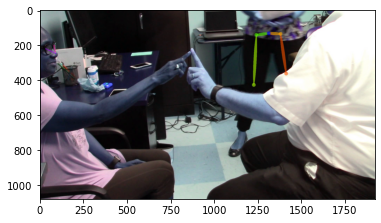

In [744]:
import matplotlib.pyplot as plt

plt.imshow(frame)

In [332]:
A1 = 2*np.pi/11

In [336]:
Y_in = np.sin(A1*np.linspace(0,11,12))
X_in = np.cos(A1*np.linspace(0,11,12))

In [339]:
offset = A1*3/2
Y_out = 2*np.sin(A1*np.linspace(0,10,11)+offset)
X_out = 2*np.cos(A1*np.linspace(0,10,11)+offset)

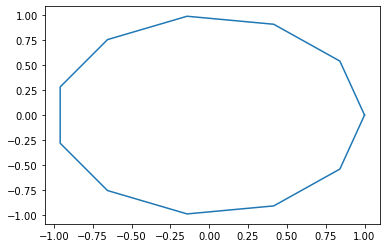

In [345]:
plt.plot(X_in,Y_in)

In [342]:
X = []
Y = []
for i in range(len(Y_out)):
    Y+=[Y_in[i], Y_out[i]]
    X+=[X_in[i], X_out[i]]
    
X.append(X_in[-1])
Y.append(Y_in[-1])

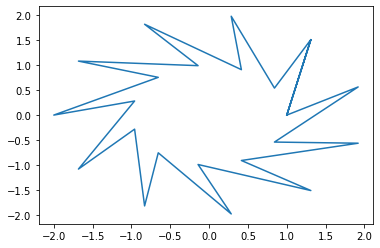

In [344]:
plt.plot(X,Y)

In [352]:
offset = A1*4/2
Y_out = 2*np.sin(A1*np.linspace(0,10,11)+offset)
X_out = 2*np.cos(A1*np.linspace(0,10,11)+offset)

In [353]:
X = []
Y = []
for i in range(0,44,4):
    i = np.mod(i,11)
    Y+=[Y_in[i], Y_out[i]]
    X+=[X_in[i], X_out[i]]
    
X.append(X_in[-1])
Y.append(Y_in[-1])

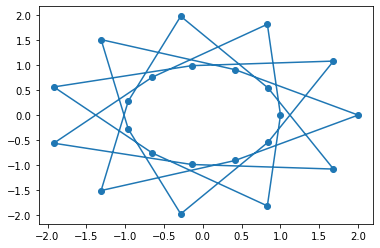

In [355]:
plt.plot(X,Y)
plt.scatter(X[:-1],Y[:-1])

In [519]:
def plotShape(n1,n2):
    A1 = 2*np.pi/n1
    
    Y_in = np.sin(A1*np.linspace(0,n1,n1+1))
    X_in = np.cos(A1*np.linspace(0,n1,n1+1))
    
    offset = A1*n2/2
    Y_out = 10*np.sin(A1*np.linspace(0,n1-1,n1)+offset)
    X_out = 10*np.cos(A1*np.linspace(0,n1-1,n1)+offset)
    
    X = []
    Y = []
    for i in range(0,n1*n2,n2):
        i = np.mod(i,n1)
        Y+=[Y_in[i], Y_out[i]]
        X+=[X_in[i], X_out[i]]

    X.append(X_in[-1])
    Y.append(Y_in[-1])
    
    plt.plot(X,Y)
    plt.scatter(X[:-1],Y[:-1])

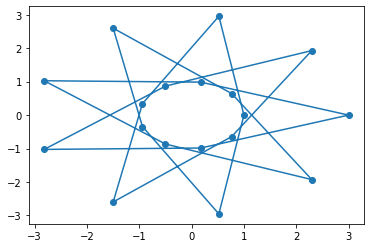

In [378]:
plotShape(9,4)

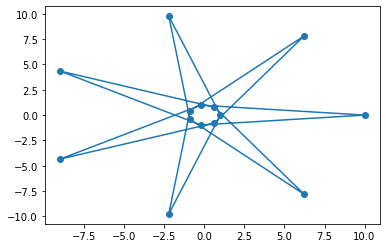

In [520]:
plotShape(7,4)